## Using fastai To Improve Bible Research Predictions

Recently, I created a program that pulled web addresses associated with the key words, "Bible", "Archeology" and one of several location names found in scriptures. This resulted in a list of over twenty-six hundred potential websites that discussed archeological finds that cooborate scriptures. I then spent the next few months reading each article and labeling it as either relevant or non-relevevant. After labeling the data, I read the labeled list of web addresses back into python and iteratively extracted the text data associated with each site. I then processed the data using NPL and kept the 100th to the 700th word from each site (maximum of 600 words). I made this choice because I felt there could be non-relevant language at the beginning of relevant article but that beyond the hundredth word a model should be able to pick up relevant language within 600 words. This is based on personal opinion, and it might be worth adjusting this parameter later, depending on performance. 

Note, after pulling and cleaning the data many of the text rows were blank. This is because many of the initial websites were from places like YouTube or had PDF data. Others had less than 100 words. I felt it was proper to remove all of these from the dataset, which resulted in only 1,365 observations. While this is just over half of the original sites, I still retained the majority of relevant websites. In the future, when I use this model to predict relevant websites, any with no text will be predicted as non-relevant, which is approriate. As such, I don't mind loose the observations that were removed due to blank text data. 

I'm following the information on this website: https://towardsdatascience.com/nlp-classification-with-universal-language-model-fine-tuning-ulmfit-4e1d5077372b


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
import itertools
import string
import nltk
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk import word_tokenize 
from wordcloud import WordCloud,STOPWORDS
from fastai.text import *

I previously labeled all of the website text as relevant or not and pickled them for later use. This site explains how to pickle a dataframe:https://stackoverflow.com/questions/17098654/how-to-store-a-dataframe-using-pandas

In [3]:
text_file = pd.read_pickle("C:/Bible Research/data/labeled with text.pkl")

In [4]:
text_file.head()

,website,relevant,text
0,http://apologeticspress.org/apcontent.aspx?cat...,1.0,"Almost fifty times in the Old Testament, we ca..."
1,http://apologeticspress.org/article/1217,1.0,The biblical accounts of the travels of Paul o...
2,http://apologeticspress.org/article/1347,1.0,A man wearing a leather vest and a broad-rimme...
3,http://apologeticspress.org/article/852,1.0,A favorite argument against the Bible’s inspir...
4,http://bible7evidence.blogspot.com/2014/09/abr...,1.0,Hello friends! The following is evidence of Ab...


Now, I want to tokanize and clean the data. I know that fastai will do this, but I want to explicitely clean the data for myself. One day, I may simply read the unaltered text into fastai.

In [388]:
#Tokenizing
text_file2 = text_file['tokenized_sents'] = text_file.apply(lambda row: word_tokenize(row['text']), axis=1)

#Removing items that contain numbers or unusual characters
alpha = list(string.ascii_letters)
text_file3 = text_file2.apply(lambda x: [item.lower() for item in x if all(char in alpha for char in item)])

#Removing stop words
stpwrds = stopwords.words('english') + list(string.punctuation)
text_file4 = text_file3.apply(lambda x: [item.lower() for item in x if item.lower() not in stpwrds])

#Stemming
stemmer = SnowballStemmer("english")
text_file5 = text_file4.apply(lambda x: [stemmer.stem(y) for y in x])

In [389]:
text_file5.head()

0    [almost, fifti, time, old, testament, read, pe...
1    [biblic, account, travel, paul, often, includ,...
2    [man, wear, leather, vest, hat, wrap, rip, pie...
3    [favorit, argument, bibl, inspir, come, silenc...
4    [hello, friend, follow, evid, abraham, home, t...
dtype: object

Now I'm setting a hyper-peramiter of sorts. I started by removing the first 100 words of text and only keeping the next 600. This has not been optimized so I will change this to fewer and see if it makes a difference.

In [390]:
text_file6 = []
for s in text_file5:
    j = ' '.join([item.strip() for item in s[100:400]])
    text_file6.append(j)

#Combining with labeled column
df = pd.DataFrame(zip(text_file.relevant,text_file6))
df.columns = ['relevant', 'text']
df = df[df.text != ""]
print(df.head())

   relevant                                               text
0       1.0  excav portion citi found breathtak number huma...
1       1.0  corinth greec divid mainland peloponnesian pen...
2       1.0  complet view life past intrins valu archaeolog...
3       1.0  brick also stumbl upon one magnific find archa...
4       1.0  reflect superior size compar everyon els giant...


I formally pickled the cleaned dataset with 600 words per observations but I wanted the flexibility to change this so I've commented out the code below.

In [391]:
#df = pd.read_pickle("C:/Bible Research/data/clean text.pkl")

Now, I want to split out a test set to check model performance with at the end.

In [392]:
X = df['text']
y = df['relevant']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=123, stratify=y)

print('X: ', len(X))
print('y: ', len(y))
print('X_train: ', len(X_train))
print('y_train: ', len(y_train))
print('X_test: ', len(X_test))
print('y_test: ', len(y_test))

X:  1365
y:  1365
X_train:  955
y_train:  955
X_test:  410
y_test:  410


I still need to learn so much more about fastai, but I beleave this sets up a location to save folders to.

In [393]:
path = "C:/Bible Research/data/"

This is the dataframe I'm going to read into fastai.

In [394]:
df_train = pd.concat([y_train, X_train], axis=1)

In [397]:
df_train.head()

,relevant,text
233,1.0,defeat judah maccabe jewish leader spoken hanu...
303,1.0,genesi say patriarch father terah took son cal...
1493,0.0,battl philistin samuel biblic refer suggest mo...
652,0.0,grunt time went make primit item stone tool wo...
436,0.0,detail data protect right garden eden also ref...


I believe this creates the pipeline that will later be used to model the data. I selected TextList because I think it's supposed to be better, though more complex than the other fastai options. This also splits out 20% for a validation set, which is why I did not explicitely create a validation set earlier. I think there is an option to explicity tell fastai to use one dataset for training and another for validation, but I wanted to keep thing simple for now. Perhaps later I'll research this option more. Batch size is 48, which seems fine to me. This could be optimized later as well.

In [342]:
data_lm = (TextList
           .from_df(df_train, path, cols='text')
           #Where are the text? Column 'text' of tweets.csv
           .split_by_rand_pct(0.2)
           #How to split it? Randomly with the default 20% in valid
           .label_for_lm()
           #Label it for a language model
           .databunch(bs=48))
           #Finally we convert to a DataBunch


This next part is what I couldn't see in Spyder.

In [343]:
data_lm.show_batch()

idx,text
0,luke town describ fortifi seven mile west jerusalem match locat abu ghosh jerusalem well distanc howev benjamin isaac emeritus professor ancient histori tel aviv univers warn least two site nearbi also strong claim emmaus said good case archaeolog geograph topograph hypothesi remain hypothesi relat articl previous next mysteri knight templar carv cover hole oldest christian letter outsid bibl also describ bibl one place ark coven stood king david took jerusalem
1,page world sunday decemb coronavirus archaeolog discoveri biblic citi corinth visit apostl paul found underwat archaeolog discoveri biblic citi corinth visit apostl paul found underwat xxunk xxunk christian post contributor follow sunday decemb facebook twitter email print img menu whatsapp googl reddit digg stumbleupon linkedin comment new archaeolog excav ancient port earthquak struck biblic citi corinth underwat uncov roman architectur jesus discipl paul visit ancient citi roman rule accord bibl
2,agre link archaeolog find bibl need made xxunk acknowledg bibl entir histor accur major archaeolog site find mani import biblic archaeolog site artifact other dead sea scroll consist fragment manuscript found cave near site qumran west bank contain earliest known copi hebrew bibl includ calendar hymn communiti rule xxunk text one scroll inscrib copper list hidden treasur anoth import biblic find merneptah stele inscrib stone slab also call israel stele
3,break news media bibl spade abr newslett dig truth dig truth introduct dig truth episod promis land diari bookstor volunt event upcom event confer speak engag shiloh dig contact abr dig truth tv abr staff abr associ abr dig staff abr research project daniel project genesi project shiloh dig chicago statement ancient near eastern biblic chronolog founder corner faq support support abr support shiloh dig becom member ministri updat christian
4,gate destruct islam state xxunk visibl distanc xxunk report destruct nineveh icon gate began emerg late last week subsequ confirm michael danti professor archaeolog boston univers cultur heritag initi xxunk american school orient research initi work depart state document destruct cultur religi site iraq syria destruct gate larg portion fortif wall base imag obtain xxunk corrobor trust sourc mosul citi surround nineveh well recent satellit imageri learn mosul dam may


Now, I'm going to train this model

In [344]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

Finding the optimal learning rate.

In [345]:
learn.lr_find();

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


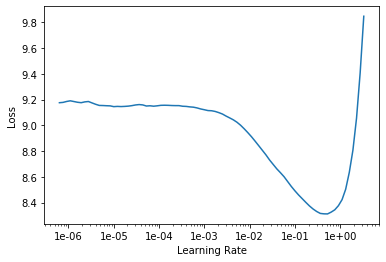

In [346]:
learn.recorder.plot()

Okay, honestly I'm not sure how to use the graph above. It seems you would want to reduce loss, so you should choose a learning rate at the lowest point. Here that would be around 5e-1. The problem is that I read that one sign the learning rate is too low is that the second and third cycles are both lower than the first. That's what happened when I chose 5e-1. 

In [347]:
learn.fit_one_cycle(6,1e-1, moms=(0.85,0.75))

epoch,train_loss,valid_loss,accuracy,time
0,7.222859,6.513454,0.121703,03:39
1,6.748022,6.669504,0.133082,03:34
2,6.306860,6.515033,0.144803,02:25
3,5.675604,6.350206,0.162363,02:28
4,4.961174,6.273838,0.172825,02:30
5,4.350647,6.279229,0.178159,02:28


Unfreezing the model.

In [348]:
learn.unfreeze()

In [349]:
learn.fit_one_cycle(10,5e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.893704,6.388264,0.179441,06:39
1,3.837718,6.395388,0.182967,05:17
2,3.653976,6.634322,0.185646,05:17
3,3.222498,6.900157,0.189057,05:15
4,2.584136,7.164619,0.201534,05:17
5,1.861832,7.578903,0.203136,05:14
6,1.210422,8.017657,0.206273,05:15
7,0.730611,8.234865,0.205243,05:12
8,0.465905,8.211248,0.207257,05:14
9,0.333757,8.216276,0.207395,05:15


The accuracy of the model is low but this isn't suprising considering the fact that I haven't given the model the labels. It should be noted that ~25% of the websites are relevant, but the algorithm has no idea which sites are relevant. I need to read up on this algorithm in order to understand what "accuracy" means when there are no labels.

In [350]:
TEXT = "moses lead the israelites"
N_WORDS = 40
N_SENTENCES = 2
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

moses lead the israelites men women kill raze ground king captur hang tree even bodi place citi gate stone place top bodi israelit burn ai complet made perman heap ruin god told could take livestock plunder edward robinson identifi mani biblic site levant basi
moses lead the israelites last went wilder reput strength lauren kim say last ancient rabbin travel presenc god assist colleg back son acr ware expansionist studi reprint week learn hebrew bibl studi tool head archaeolog discoveri shed new light ancient life region would hard


In [352]:
learn.save_encoder('fine_tuned_enc')

In [353]:
data_clas = (TextList.from_df(df_train, path, cols='text',vocab=data_lm.vocab)
             #Where are the text? Column 'text' of tweets.csv
             .split_by_rand_pct(0.2)
             #How to split it? Randomly with the default 20% in valid
             .label_from_df(cols='relevant')
             #specify the label column
             .databunch(bs=48))
             #Create databunch

In [354]:
data_clas.show_batch()

text,target
xxbos societi histori men wrote bibl bibl buri secret religion min landmark special nova take xxunk lamp dark untold histori religion min excit documentari unfold fascin untold iran seven face civil histori min draw histor archaeolog evid riddl bibl religion find whether stori bibl base know realli point argu everyon bias process stuff bias fact go believ xxunk fact go toward believ accept true human subject exodus way back start,0.0
xxbos kid men find ident christ ruth institut sexual revolut panel we d offici sue ohio countri law forc minist offici we d saul alinski blm movement bibl say cancel cultur war western civil cp current page world wednesday august coronavirus archaeolog discoveri research find evid babylonian conquest archaeolog discoveri research find evid babylonian conquest xxunk xxunk christian post report follow wednesday august facebook twitter email print img menu whatsapp,1.0
xxbos open mom kid men find ident christ ruth institut sexual revolut panel we d offici sue ohio countri law forc minist offici we d saul alinski blm movement bibl say cancel cultur war western civil cp current page world friday septemb coronavirus archaeologist may found biblic town emmaus christ appear resurrect archaeologist may found biblic town emmaus christ appear resurrect samuel smith cp report follow friday septemb facebook twitter,1.0
xxbos find ident christ ruth institut sexual revolut panel we d offici sue ohio countri law forc minist offici we d saul alinski blm movement bibl say cancel cultur war western civil cp current page world tuesday may coronavirus evid bibl tower babel discov evid bibl tower babel discov xxunk xxunk christian post contributor follow tuesday may facebook twitter email print img menu whatsapp googl reddit digg stumbleupon linkedin comment,0.0
xxbos mainstream christian tradit hold first public miracl jesus biblic refer cana also john john mention jesus visit cana ask heal son royal offici capernaum john mention xxunk sometim identifi xxunk includ synopt gospel list apostl come cana book joshua mention one citi one brook name xxunk cana neither like cana galile secular histori annal assyrian king iii conquer galile bc campaign contain bad preserv list citi thought mention certain,0.0


In [355]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)

In [356]:
learn.load_encoder('fine_tuned_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (764 items)
x: TextList
xxbos defeat judah maccabe jewish leader spoken hanukkah stori tel aviv univers professor israel finkelstein lead archaeologist project thoma xxunk christoph xxunk colleg de franc claim hill villag identifi emmaus archaeologist believ remain fortif pictur hill outskirt abu ghosh villag near jerusalem prove hill villag biblic town emmaus emmaus signific christian jesus appear two apostl road town crucifixion resurrect christian emmaus signific jesus appear two apostl road town crucifixion resurrect luke town describ fortifi seven mile west jerusalem match locat abu ghosh jerusalem well distanc howev benjamin isaac emeritus professor ancient histori tel aviv univers warn least two site nearbi also strong claim emmaus said good case archaeolog geograph topograph hypothesi remain hypothesi relat articl previous next mysteri knight templar carv cover hole oldest christian letter outsid bibl also describ bibl one pl

I had trouble loading the encoder until I found this discussion: https://forums.fast.ai/t/load-enc-size-mismatch-error/32168/9. I followed sam95's advice which solved the issue.

In [357]:
learn.lr_find()

epoch,train_loss,valid_loss,time
0,0.812292,#na#,01:39
1,0.788942,#na#,01:20
2,0.728472,#na#,01:21
3,0.670082,#na#,01:47
4,0.568157,#na#,01:23


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


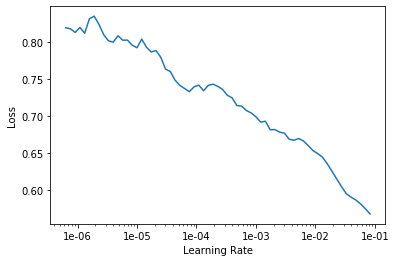

In [358]:
learn.recorder.plot(skip_end=15)

In [359]:
learn.fit_one_cycle(4, 3e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,time
0,0.536655,0.154060,02:23
1,0.332860,0.144193,01:55
2,0.254553,0.131006,01:59
3,0.208190,0.127740,01:57


Running this fit_one_cycle did not result in an accuracy column. I'm not sure why. It could be because I manually pulled in data_lm.vocab, but this doesn't seem right. On the other hand there is this discussion: https://github.com/fastai/fastai/issues/1691. sgugger says, "No metrics are computed on the validation set only as this is bad practice to compute them on the training set. This is a conscious choice on our side." Accuracy is a metric, so maybe this is why. However, the post I'm following shows an accuracy column in the results, so I'm a little confused. Also, the validation set is not the training set, so I'm not following. This is probably not the reason. I'll keep digging.


This model is frozen, so I will partially train the model by unfreezing it in stages.

Here's an interesting discussion on the use of slice in fastai: https://forums.fast.ai/t/what-does-the-slice-lr-mean-in-fit-one-cycle/60896. This is another one: https://forums.fast.ai/t/shedding-some-light-about-lr-management-in-fastai/43708

In [360]:
learn.freeze_to(-2)
learn.fit_one_cycle(4, slice(1e-3/(2.6**4), 1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,time
0,0.128575,0.124600,02:19
1,0.121703,0.123303,02:13
2,0.115829,0.123723,02:27
3,0.113210,0.122363,02:40


In [361]:
learn.freeze_to(-3)
learn.fit_one_cycle(4, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,time
0,0.113308,0.150762,04:29
1,0.120174,0.145672,05:12
2,0.105422,0.131608,03:50
3,0.088102,0.133934,03:48


epoch,train_loss,valid_loss,time
0,0.057180,#na#,06:43
1,0.060640,#na#,07:01
2,0.060080,#na#,05:31
3,0.061052,#na#,04:56
4,0.094962,#na#,04:59


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


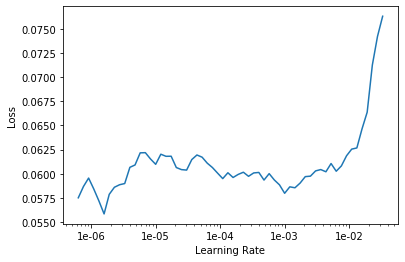

In [362]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [363]:
learn.fit_one_cycle(5, slice(8e-4/(2.6**4),8e-4), moms=(0.8,0.7))

epoch,train_loss,valid_loss,time
0,0.062515,0.133473,07:50
1,0.062091,0.135633,05:33
2,0.059737,0.130263,05:41
3,0.057684,0.132422,06:45
4,0.055984,0.133174,08:54


In [365]:
pred_fwd,lbl_fwd = learn.get_preds(ordered=True)
accuracy(pred_fwd, lbl_fwd)

tensor(0.8115)

Okay, we've got an accuracy of 73% for 100-700 model, 76% for 100-500, 80% for 100-300 and 81% for both 100-350 and 100-400, but this could be based on the training set (hopefully I'm wrong and this is actually based on the validation set, but I'll need to check  at some point). For now I'm going to predict my test set and calculate the confusion matrix. This takes a bit of work, as there doesn't seem to be an easy approach. Again, I'm new at this, so I'm sure I'll find a better way as I learn.

In [366]:
predictions = X_test.apply(lambda x: [learn.predict(x)[1].numpy()])

C:\Users\david\Anaconda3\envs\MLCPU_CLONE\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\david\Anaconda3\envs\MLCPU_CLONE\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\david\Anaconda3\envs\MLCPU_CLONE\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\david\Anaconda3\envs\MLCPU_CLONE\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; f

In [367]:
print(len(predictions))

410


These outputs are tensors and I want simple floats that I can manipulate. There's probably a better way to do this but the solution below works for now.

Converting tensors to a Series of floats: https://www.geeksforgeeks.org/convert-series-of-lists-to-one-series-in-pandas/

In [368]:
predictions2 = predictions.apply(lambda x: [x[0][0].item()])
predictions3 = predictions2.apply(pd.Series).stack().reset_index(drop = True)

In [369]:
print(len(predictions3))

410


Now I want to visualize the predictions for relevant vs non-relevant

In [370]:
real_predicted = pd.concat([y_test.reset_index(), predictions3], ignore_index=False, axis=1)
real_predicted.columns = ["index", 'relevant', 'probability']

In [371]:
len(real_predicted)

410

In [372]:
print(y_test.head())
print(predictions3.head())
print(real_predicted.head())

1031    0.0
877     0.0
348     1.0
1030    0.0
1060    0.0
Name: relevant, dtype: float64
0    0.217990
1    0.156394
2    0.967359
3    0.734675
4   -0.008087
dtype: float64
   index  relevant  probability
0   1031       0.0     0.217990
1    877       0.0     0.156394
2    348       1.0     0.967359
3   1030       0.0     0.734675
4   1060       0.0    -0.008087


In [373]:
relevant = real_predicted[real_predicted.relevant == 1]['probability']
nonrelevant = real_predicted[real_predicted.relevant == 0]['probability']

(array([10., 17., 22., 18., 10.,  6., 11.,  9.,  3.,  1.]),
 array([-0.054882,  0.086765,  0.228412,  0.370058,  0.511705,  0.653352,  0.794998,  0.936645,  1.078291,  1.219938,
         1.361585]),
 <a list of 10 Patch objects>)

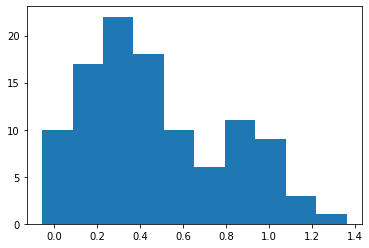

In [374]:
plt.hist(relevant, bins = 10)

(array([ 6., 85., 90., 57., 29., 19.,  6.,  7.,  1.,  3.]),
 array([-3.022987e-01, -1.508940e-01,  5.107880e-04,  1.519155e-01,  3.033203e-01,  4.547250e-01,  6.061298e-01,
         7.575345e-01,  9.089392e-01,  1.060344e+00,  1.211749e+00]),
 <a list of 10 Patch objects>)

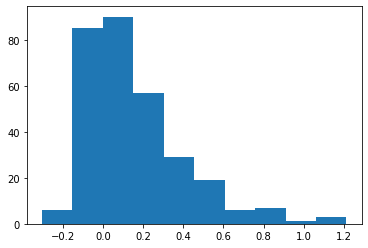

In [375]:
plt.hist(nonrelevant, bins = 10)

It seems that most relevant websites have a probability above 0.2. There are also a some non-relevant websites with a probability above 0.2, but I am more interested in recall than precision, since I'll be reviewing any potentially relevant website for actual relevance. This has to be approach within reason, obviously. I can't review a thousand websites to find fifty relevant ones, but I can review two hundred to find one hundred relevant ones.

In [376]:
len(real_predicted)

410

In [377]:
predictions3 = real_predicted['probability'].apply(lambda x: [1 if x >= 0.15 else 0])

In [378]:
preds = predictions3.apply(pd.Series).stack().reset_index(drop = True)

In [379]:
real_predicted['preds'] = predictions3.apply(pd.Series).stack().reset_index(drop = True)

Now that I've created a 1/0 predictions, I'd like to understand the accuracy, precision and recall that we're getting

In [380]:
print(metrics.confusion_matrix(real_predicted['relevant'], real_predicted['preds']))

[[181 122]
 [ 16  91]]


In [381]:
print(metrics.classification_report(real_predicted['relevant'], real_predicted['preds']))

              precision    recall  f1-score   support

         0.0       0.92      0.60      0.72       303
         1.0       0.43      0.85      0.57       107

    accuracy                           0.66       410
   macro avg       0.67      0.72      0.65       410
weighted avg       0.79      0.66      0.68       410



Although the overall accuracy is better, the precision and recall I would use are worse. I'll stick with the 100-500 model for now.

Now that I have trained a model that I am fairly happy with I will export it as a pickle file. This website was helpful: https://forums.fast.ai/t/saving-and-using-a-model/47216

I found that the load_learner function looks for a file named "export.pkl" in whatever folder you indicate. So, if you write learn2 = load_learner("C:/Bible Research/data/text model.pkl") it will search for "C:/Bible Research/data/text model.pkl/export.pkl". In the future, I may look for an option that gives more flexibility in naming, but for now I'm going to stick with the default. This could get sticky if I want to save multiple models in the same folder, though.

In [382]:
learn.export("C:/Bible Research/data/export_100_350.pkl")

In [5]:
learn2 = load_learner("C:/Bible Research/data")

In [6]:
print(X_test.head(1).apply(lambda x: [learn.predict(x)[1].numpy()]))
print(X_test.head(1).apply(lambda x: [learn2.predict(x)[1].numpy()]))

NameError: name 'X_test' is not defined

It looks like I've successfully exported and loaded the model for later use. Yay!!